# Pages Sampling
This notebook generates `samples` of pages from the full canonical data. These pages and their corresponding components (e.g. bounding boxes of images, tables, articles) will be used in train, validation and test sets for future finetuning of (layout) segmentation models.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sampling functions
def strat_helper(df, N_sample, N, rand=1):
    n = len(df)
    n_sample = round(N_sample * n / N)
    return df.sample(n_sample, random_state=rand)

def stratified_sample(df, col, random_state=1, N_sample=50000):
    return df.groupby(col, group_keys=False).apply(lambda x: strat_helper(x, N_sample, len(df), random_state)).reset_index(drop=True)

def uniform_sample(df, col, random_state=1, n_sample=10000):
    return df.groupby(col, group_keys=False).apply(lambda x: x.sample(n_sample, random_state=random_state) if len(x) > n_sample else x)

### Load and Prepare Data for Sampling

In [3]:
# read the parquet file as a dataframe
issues_df = pd.read_parquet("../../data/data_preparation/issues_preprocessed.parquet.gzip")

In [4]:
# set month, year, decade
issues_df["month"] = issues_df["date"].dt.to_period("M")
issues_df["year"] = issues_df["date"].dt.year
issues_df["decade"] = (issues_df["year"] // 10) * 10

In [5]:
# get page number
issues_df["page_num"] = issues_df["pp"].apply(lambda x: int(x.split("-p")[-1]))

# assign page group
def assign_page_group(page_number):
    if page_number <= 8:
        return str(page_number)
    elif page_number <= 20:
        return "9-20"
    else:
        return "21+"
    
issues_df["page_grp"] = issues_df["page_num"].apply(assign_page_group)

In [6]:
# get dataframe of unique pages to sample
pages_df = issues_df[["journal", "pp", "date", "month", "year", "decade", "page_num", "page_grp"]].drop_duplicates(subset="pp")
pages_df.sample(5)

,journal,pp,date,month,year,decade,page_num,page_grp
821421,jdpl,jdpl-1880-11-22-a-p0001,1880-11-22,1880-11,1880,1880,1,1
916961,indeplux,indeplux-1924-03-26-a-p0003,1924-03-26,1924-03,1924,1920,3,3
719441,luxwort,luxwort-1946-09-21-a-p0006,1946-09-21,1946-09,1946,1940,6,6
585885,lematin,lematin-1900-02-10-a-p0003,1900-02-10,1900-02,1900,1900,3,3
665692,lematin,lematin-1926-02-24-a-p0006,1926-02-24,1926-02,1926,1920,6,6


In [7]:
# remove journals based on pages preprocessing
rm_journals = ["tageblatt"]
pages_df = pages_df[~pages_df["journal"].isin(rm_journals)]

### Load Full Impresso Corpus Statistics

In [8]:
# path to the full impresso corpus metadata
file_path = "../../data/data_preparation/full_impresso_corpus/canonical_v4-5-0.json"

# open the JSON file and load it into a dictionary
with open(file_path, 'r') as file:
    impresso_data = json.load(file)
    
print(impresso_data.keys())

dict_keys(['mft_version', 'mft_generation_date', 'mft_s3_path', 'input_mft_s3_path', 'input_mft_git_path', 'code_git_commit', 'media_list', 'overall_statistics', 'notes'])


In [9]:
# get all media in impresso corpus
total_media = []
for media in impresso_data["media_list"]:
    total_media.append(media["media_title"])
total_media = list(set(total_media))

In [10]:
# get media of interest for this project
media_of_interest = list(set(pages_df["journal"]))
print(f"{len(media_of_interest)} media are selected in this project out of {len(total_media)} from the full impresso corpus.")

36 media are selected in this project out of 134 from the full impresso corpus.


In [11]:
corpus_stats = []

for media in impresso_data["media_list"]:
    #if media["media_title"] in media_of_interest:
    for stat in media["media_statistics"]:
        if stat["granularity"] == "year":
            row = {
                "journal": media["media_title"],
                "element": stat["element"]
            }
            row.update(stat["nps_stats"])  # add `nps_stats` keys and values as columns
            corpus_stats.append(row)       # append the row to the list
            
corpus_stats = pd.DataFrame(corpus_stats)

corpus_stats.sample(5)

,journal,element,issues,pages,content_items_out,images
2153,NZG,NZG-1855,52,213,622,NaN
314,EXP,EXP-1974,301,8293,131764,10556.0
1190,IMP,IMP-1965,304,7225,82452,7658.0
351,EXP,EXP-2011,304,9862,86626,26966.0
1259,JDG,JDG-1838,85,366,1148,12.0


In [12]:
# split media from year and derive decade
corpus_stats["year"] = corpus_stats["element"].apply(lambda x: x.split("-")[1]).astype(int)
corpus_stats["decade"] = (corpus_stats["year"] // 10) * 10
corpus_stats.sample(5)

,journal,element,issues,pages,content_items_out,images,year,decade
4202,NV2,NV2-1871,309,1252,3270,1648.0,1871,1870
567,FedGazDe,FedGazDe-1860,67,1835,236,NaN,1860,1860
4235,esta,esta-1876,299,1367,2493,879.0,1876,1870
3536,luxwort,luxwort-1852,156,625,2096,NaN,1852,1850
1680,LCS,LCS-1830,105,420,750,1.0,1830,1830


### Sampling
- stratified by year
- uniform over journals within each year
- stratified by page number within the journal

In [13]:
# sampling function

def stratified_sampling(df, N, year_col="year", journal_col="journal", page_col="page_grp", full_corpus_stats=[]):
    # 1 - Stratify by year: calculate proportionate number of samples per year
    if len(full_corpus_stats) > 1:
        print("Taking the full impresso corpus into consideration... ")
        possible_years = list(set(pages_df[year_col])) # get years of interest for the project based on media of interest
        full_corpus_stats = full_corpus_stats[full_corpus_stats["year"].isin(possible_years)]
        
        year_counts = full_corpus_stats.groupby(year_col)["pages"].sum()
        year_counts = year_counts / year_counts.sum() # normalize the counts
        year_samples = (year_counts * N).round().astype(int)
    else:
        print("Not taking the full impresso corpus into consideration... ")
        year_counts = df[year_col].value_counts(normalize=True)
        year_samples = (year_counts * N).round().astype(int)
    
    sampled_data = []
    total_samples_taken = 0
    
    for year, num_samples_year in year_samples.items():
        df_year = df[df[year_col] == year]
        
        # 2 - Uniform sampling over journals within each year
        journals = df_year[journal_col].unique()
        if len(journals) == 0:
            print(f"No journals found for year {year}. Skipping this year.")
            continue  # skip this year if no journals are found
        
        samples_per_journal = num_samples_year // len(journals)
        remaining_samples = num_samples_year - (samples_per_journal * len(journals))
        
        # adjust for small journals
        for journal in journals:
            df_journal = df_year[df_year[journal_col] == journal]
            
            # if the journal has fewer entries than the required samples, take all entries
            journal_size = len(df_journal)
            samples_for_journal = min(samples_per_journal, journal_size)
            
            # if there are remaining samples (due to rounding), distribute them
            if remaining_samples > 0:
                samples_for_journal += 1
                remaining_samples -= 1
            
            # 3 - Stratified sampling by page number within the journal
            page_counts = df_journal[page_col].value_counts(normalize=True)
            page_samples = (page_counts * samples_for_journal).round().astype(int)
            
            for page, num_samples_page in page_samples.items():
                df_page = df_journal[df_journal[page_col] == page]
                
                # ensure we sample only up to the number of available rows (don't exceed available data)
                sampled_data.append(df_page.sample(n=min(num_samples_page, len(df_page)), random_state=42))
                total_samples_taken += min(num_samples_page, len(df_page))

    # if the number of samples is less than N, sample the remaining entries randomly
    if total_samples_taken < N:
        remaining_samples = N - total_samples_taken
        remaining_data = df[~df.index.isin(pd.concat(sampled_data).index)]
        sampled_data.append(remaining_data.sample(n=remaining_samples, random_state=42))
        
    # combine all samples
    return pd.concat(sampled_data).reset_index(drop=True)

In [14]:
full_corpus_stats = corpus_stats[["pages", "year", "decade"]]

# define test set
N = 5000
# test_sample = stratified_sampling(pages_df, N)[["journal", "pp"]] # comment if we want to take the whole impresso corpus into consideration
test_sample = stratified_sampling(pages_df, N, full_corpus_stats=full_corpus_stats)[["journal", "pp"]]
print(f"Test set length: {len(test_sample):,}")

# define small train-validation set
N = 50000
# train_small_sample = stratified_sampling(pages_df[~pages_df["pp"].isin(test_sample["pp"])], N)[["journal", "pp"]]
train_small_sample = stratified_sampling(pages_df[~pages_df["pp"].isin(test_sample["pp"])], N, full_corpus_stats=full_corpus_stats)[["journal", "pp"]]
print(f"Small Train set length: {len(train_small_sample):,}")

# define large train-validation set
N = 150000
# train_large_sample = stratified_sampling(pages_df[~pages_df["pp"].isin(test_sample["pp"])], N)[["journal", "pp"]]
train_large_sample = stratified_sampling(pages_df[~pages_df["pp"].isin(test_sample["pp"])], N, full_corpus_stats=full_corpus_stats)[["journal", "pp"]]
print(f"Large Train set length: {len(train_large_sample):,}")

Taking the full impresso corpus into consideration... 


Test set length: 5,000
Taking the full impresso corpus into consideration... 
No journals found for year 1951. Skipping this year.
Small Train set length: 50,000
Taking the full impresso corpus into consideration... 
No journals found for year 1951. Skipping this year.
Large Train set length: 150,000


In [15]:
# rename page column
test_sample = test_sample.rename(columns={"pp": "page_id"})
train_small_sample = train_small_sample.rename(columns={"pp": "page_id"})
train_large_sample = train_large_sample.rename(columns={"pp": "page_id"})

In [16]:
# save pages
test_sample.to_csv("/scratch/students/danae/data/data_preparation/samples/pages/test.csv", index=False)
train_small_sample.to_csv("/scratch/students/danae/data/data_preparation/samples/pages/train_small.csv", index=False)
train_large_sample.to_csv("/scratch/students/danae/data/data_preparation/samples/pages/train_large.csv", index=False)

### Visualize sampling

In [20]:
train_large_sample["journal"].value_counts()

journal
luxland            42235
luxwort            16036
jdpl               12608
obermosel           8442
lepetitparisien     8371
legaulois           8276
indeplux            7866
lematin             7180
oeuvre              5239
lepji               3327
oerennes            3031
courriergdl         2513
oecaen              2471
armeteufel          2055
waechtersauer       1960
excelsior           1788
buergerbeamten      1772
waeschfra           1690
onsjongen           1530
actionfem           1478
lunion              1474
deletz1893          1362
marieclaire         1217
dunioun             1096
luxembourg1935      1011
volkfreu1869         954
lafronde             893
diekwochen           523
avenirgdl            461
demitock             343
luxzeit1858          224
schmiede             217
luxzeit1844          104
gazgrdlux            101
landwortbild          85
kommmit               67
Name: count, dtype: int64

In [17]:
train_large_sample["year"] = train_large_sample["page_id"].apply(lambda x: int(x.split("-")[1]))

# group by year to get yearly counts
yearly_counts = pages_df.groupby("year").size().reset_index(name="count")
yearly_counts_sample = (
    train_large_sample.groupby("year").size().reset_index(name="count")
)

# map colors to decades
yearly_counts["decade"] = (yearly_counts["year"] // 10) * 10
unique_decades = sorted(yearly_counts["decade"].unique())

yearly_counts_sample["decade"] = (yearly_counts_sample["year"] // 10) * 10

# assign a distinct color to each decade using seaborn
palette = sns.color_palette("tab10", len(unique_decades))
decade_colors = {decade: palette[i] for i, decade in enumerate(unique_decades)}

# map colors to the `yearly_counts` DataFrame based on the decade
yearly_counts["color"] = yearly_counts["decade"].map(decade_colors)
yearly_counts_sample["color"] = yearly_counts_sample["decade"].map(decade_colors)

#### Visualization by full corpus time sampling

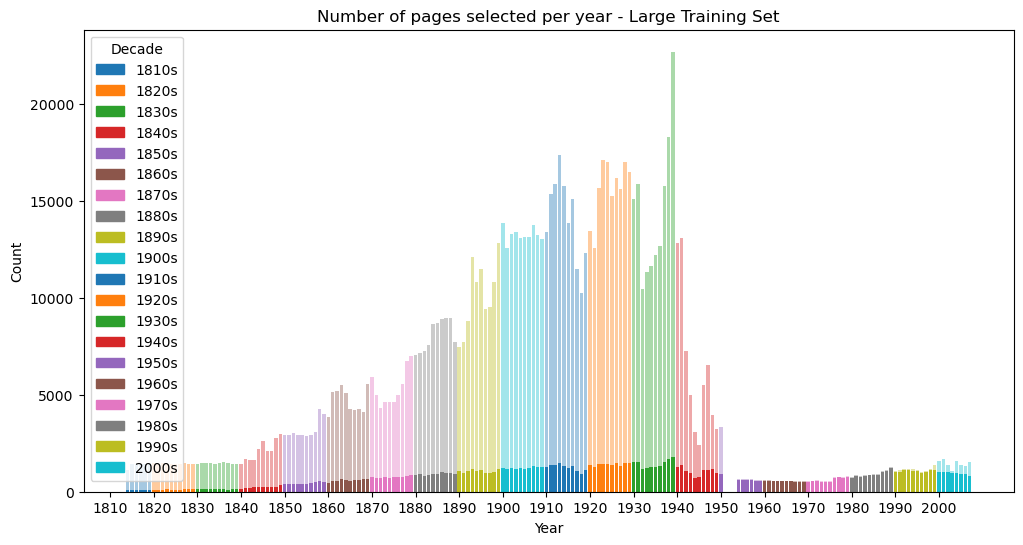

In [18]:
# plot
plt.figure(figsize=(12, 6))
plt.bar(
    yearly_counts["year"],
    yearly_counts["count"],
    color=yearly_counts["color"],
    alpha=0.4,
    label="Original Counts",
)
plt.bar(
    yearly_counts_sample["year"],
    yearly_counts_sample["count"],
    color=yearly_counts_sample["color"],
    label="Sampled Counts",
)

# plt.yscale("log")

# Adding labels and legend
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of pages selected per year - Large Training Set")
handles = [
    plt.Rectangle((0, 0), 1, 1, color=decade_colors[decade])
    for decade in unique_decades
]
labels = [f"{decade}s" for decade in unique_decades]
plt.legend(handles, labels, title="Decade")
#plt.yscale('log')

# set x-axis ticks to show only one per decade
plt.xticks(unique_decades)

plt.show()

#### Visualization by using time sampling from dataset of interest

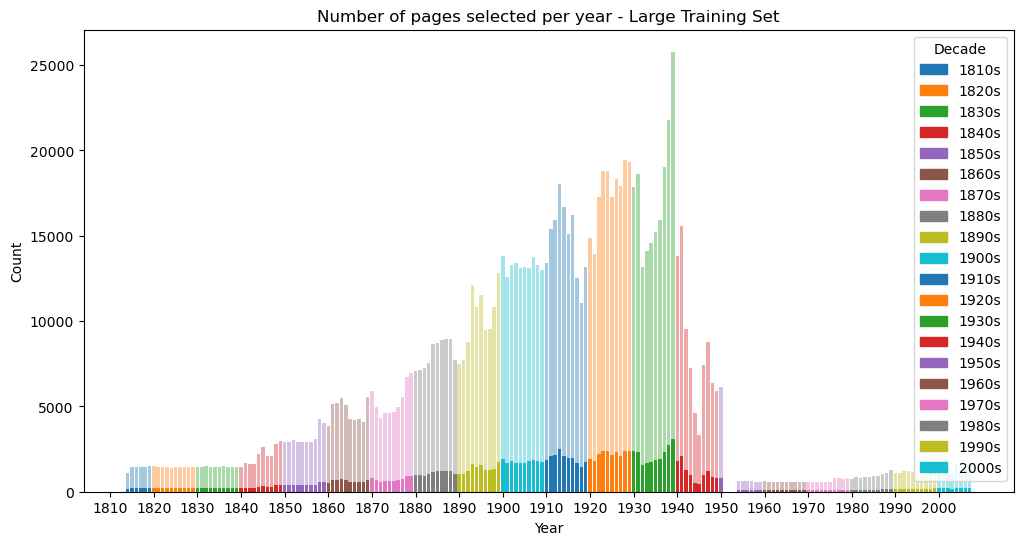

In [18]:
# plot
plt.figure(figsize=(12, 6))
plt.bar(
    yearly_counts["year"],
    yearly_counts["count"],
    color=yearly_counts["color"],
    alpha=0.4,
    label="Original Counts",
)
plt.bar(
    yearly_counts_sample["year"],
    yearly_counts_sample["count"],
    color=yearly_counts_sample["color"],
    label="Sampled Counts",
)

# plt.yscale("log")

# Adding labels and legend
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of pages selected per year - Large Training Set")
handles = [
    plt.Rectangle((0, 0), 1, 1, color=decade_colors[decade])
    for decade in unique_decades
]
labels = [f"{decade}s" for decade in unique_decades]
plt.legend(handles, labels, title="Decade")
#plt.yscale('log')

# set x-axis ticks to show only one per decade
plt.xticks(unique_decades)

plt.show()